# imports and reading

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Define image dimensions
IMG_Resize = 224
IMG_crop = 224
BATCH_SIZE = 256
# Define data directory
data_dir = "/kaggle/input/plantvillage-dataset/grayscale"

In [ ]:
# # Define the neural network architecture
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(512*7*7, 1024)
#         self.fc2 = nn.Linear(1024, targets_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv4(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv5(x)
#         x = self.relu(x)
#         x = self.maxpool(x)        
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x

# **Helper Functions**

In [3]:
def train(network, train_loader, optimizer, loss_function):
    # creating list to hold loss and accuracy per batch
    loss_per_batch = []
    acc_per_batch = []

    # iterating through batches
    print('training...')
    for images, labels in tqdm(train_loader):
        # sending images to device
        images, labels = images.to(device), labels.to(device)

        # zeroing optimizer gradients
        optimizer.zero_grad()

        # classifying instances
        classifications = network(images)

        # computing loss/how wrong our classifications are
        loss = loss_function(classifications, labels)
        loss_per_batch.append(loss.item())

        # computing gradients/the direction that fits our objective
        loss.backward()

        # optimizing weights/slightly adjusting parameters
        optimizer.step()

        # computing accuracy for the batch
        preds = torch.argmax(classifications, dim=1)
        acc = (preds == labels).sum().item() / len(labels)
        acc_per_batch.append(acc)

    # computing the overall accuracy for the training set
    train_acc = sum(acc_per_batch) / len(acc_per_batch)
    return acc_per_batch, train_acc

In [4]:
def plot_classification(model, data_loader, class_names):
    """
    Plot the classification results of a PyTorch model.

    Args:
        model: A trained PyTorch model.
        data_loader: A PyTorch DataLoader that contains the input images.
        class_names: A list of class names corresponding to the output classes of the model.
    """

    # Set the model to evaluation mode
    model.eval()

    # Create empty lists to store the true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the input data and generate predictions
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass through the model
            outputs = model(images).to(device)

            # Convert the outputs to class predictions
            _, predicted = torch.max(outputs, 1)

            # Append the true and predicted labels to the lists
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Generate the classification report
    cr = classification_report(true_labels, predicted_labels, target_names=class_names)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] > thresh else "black")
    fig.tight_layout()

    # Print the classification report
    print(cr)


In [5]:
def ACC_Plot(epochs, loss):
    plt.xlabel('Epochs') 
    plt.ylabel('accuracy')
    plt.plot(epochs, loss)

# Loading Dataset 

In [6]:
# Load the data
transform = transforms.Compose([transforms.Resize(IMG_Resize), transforms.CenterCrop(IMG_crop), transforms.ToTensor()])

image_dataset = datasets.ImageFolder(data_dir, transform=transform)

indices = list(range(len(image_dataset)))

split = int(np.floor(0.85 * len(image_dataset)))  # train_size
validation = int(np.floor(0.70 * split))  # validation

np.random.shuffle(indices)

train_indices, validation_indices, test_indices = (indices[:validation],indices[validation:split],indices[split:],)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
validation_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Defining and Training the model**

In [7]:
# Define the model, loss function and optimizer
model = models.resnet18(pretrained=True)
model = model.cuda() if device else model

targets_size = len(image_dataset.class_to_idx)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, targets_size)
model.fc = model.fc.cuda() if device else net.fc
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

# Train the model
num_epochs = 5
Acc = []
for epoch in range(num_epochs):
    Train_acc_per_batch, acc = train(model, train_loader, optimizer, criterion)
    Acc.append(acc)
    print("Epoch accuracy: ",acc)
print("Train accuracy:",acc)
print("All Done!")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training...


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch accuracy:  0.8386866947029348
training...


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch accuracy:  0.9758964522190409
training...


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch accuracy:  0.995355561023622
training...


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch accuracy:  0.9990772637795275
training...


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch accuracy:  0.999876968503937
Train accuracy: 0.999876968503937
All Done!


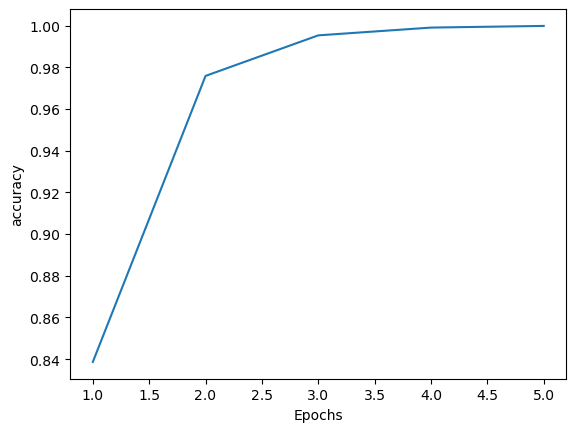

In [9]:
ACC_Plot([1,2,3,4,5], Acc)

# **Evaluating The Model**

In [8]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    Eval_acc_per_batch= []
    for inputs, labels in validation_loader:
        data_, target_ = inputs.to(device), labels.to(device)
        outputs = model(data_)
        _, predicted = torch.max(outputs.data, 1)
        total += target_.size(0)
        correct += (predicted == target_).sum().item()
        acc = (predicted == target_).sum().item() / len(target_)
        Eval_acc_per_batch.append(acc)

    print(f"validation accuracy: {correct/total:.4f}")

validation accuracy: 0.9772


In [10]:
label_Names = os.listdir(data_dir)
classes = image_dataset.class_to_idx

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.96      0.97       181
                                 Apple___Black_rot       0.97      0.99      0.98       149
                          Apple___Cedar_apple_rust       1.00      0.97      0.99        70
                                   Apple___healthy       0.98      0.99      0.99       435
                               Blueberry___healthy       0.99      1.00      0.99       394
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       236
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       226
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.87      0.86       135
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       330
               Corn_(maize)___Northern_Leaf_Blight       0.93      0.91      0.

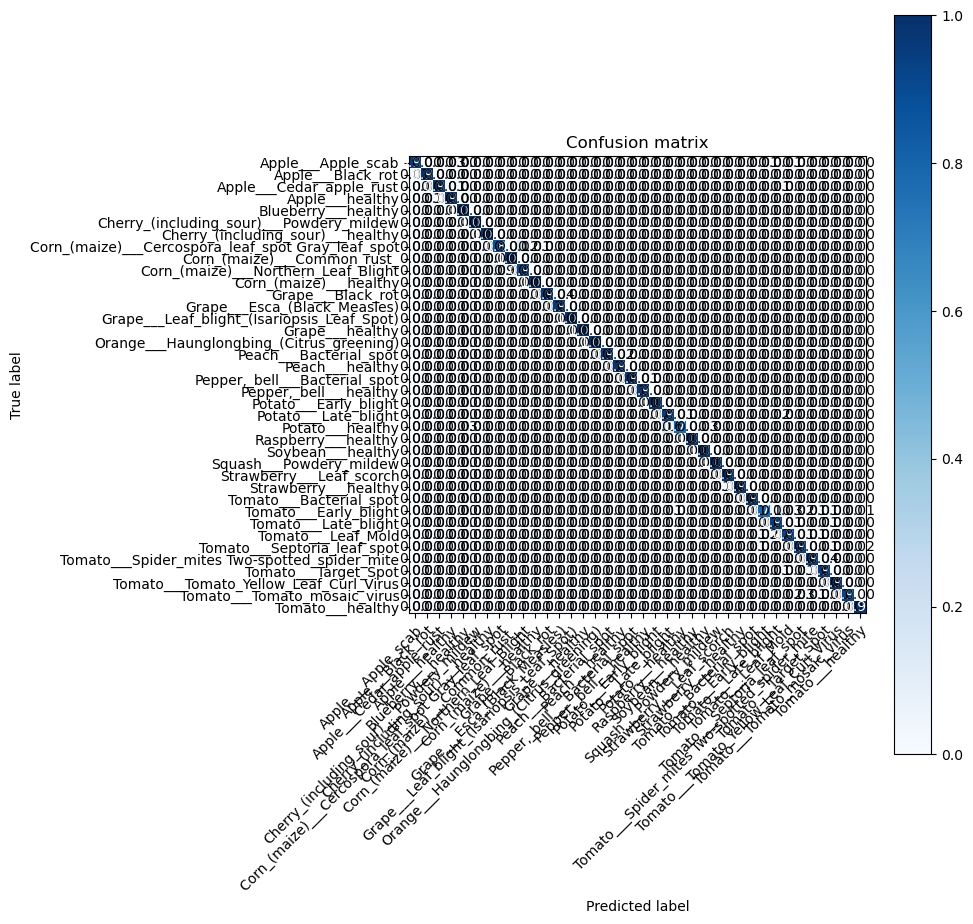

In [11]:
plot_classification(model, validation_loader, classes.keys())

In [21]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [24]:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model
# print(result)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  